In [54]:
from IPython.display import Image
%matplotlib inline

In [55]:
# run the below code
# pandasモジュールをimport
import pandas as pd
# OS 依存の機能を利用するモジュールをimport
import os

In [57]:
# ファイル読み込み
df = pd.read_csv('./movie_data_3000.csv')
print(len(df))
df.head()

3000


review  sentiment
0  In 1974, the teenager Martha Moxley (Maggie Gr...          1
1  OK... so... I really like Kris Kristofferson a...          0
2  ***SPOILER*** Do not read this, if you think a...          0
3  hi for all the people who have seen this wonde...          1
4  I recently bought the DVD, forgetting just how...          0

## データの分割
- 「学習データ」と「テストデータ」を作る
- 「学習データ」と「テストデータ」を作ることで、学習アルゴリズムの評価ができる

In [60]:
# 分割方法1
# dataframeから「学習データ」と「テストデータ」を直接つくる

# データセットの一部を使用することで、計算量を減らす
X_train = df.loc[:249, 'review'].values
y_train = df.loc[:249, 'sentiment'].values
X_test = df.loc[250:499, 'review'].values
y_test = df.loc[250:499, 'sentiment'].values

In [58]:
print(X_train[249])

this is not just a bad film, it's one of the worst films ever. it's so bad that i found it to be quite enjoyable. the acting, oh my god, the script, you gotta be kiddin'. how can you imagine the writer coming up with things like: - a kid who makes fireworks in school, fireworks SO powerfull, that when someone gets hit by it, they fly a hundred yards backwards and explode. -a girl is trapped in the celler, the killer is trying to break open the door. she gets a drill, but the wire isn't long enough. she first makes an extension cord, oh the horror, and then, when she's done, she drills through the door and drills through the head of the killer. WOW - and there are plenty more examples like that. oh yeah, and what happened to George Kennedy, he used to be great (Thunderbolt and Lightfoot/Cool hand Luke)


In [68]:
# 分割方法2（分割法１より汎用的）
# 「train_test_splitdataframe」関数を利用し、「学習データ」と「テストデータ」をつくる
from sklearn.cross_validation import train_test_split

X = df.loc[:499, 'review'].values
y = df.loc[:499, 'sentiment'].values

# 20%をテストデータ、８０%を訓練データにする。乱数のseedを1とする
X_train, X_test, y_train, y_test = \
    train_test_split(X, y, test_size=0.20,random_state=1)

In [67]:
print(len(X_train))
print(len(X_test))

400
100


### 分割したデータを使い、評価する
- 評価の際は、前処理・学習を一つの処理にまとめたほうが、便利
- まとめるため、「Pipeline」クラスを使う

In [71]:
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.linear_model import LogisticRegression

# 前処理・学習を一つのインスタンスにまとめる
pipe_lr = Pipeline([('cov',CountVectorizer(ngram_range=(1, 3))),('clf', LogisticRegression(C=0.001,penalty='l2',random_state=1))])

# 学習
pipe_lr.fit(X_train, y_train)

# 評価
print('Test Accuracy: %.3f' % pipe_lr.score(X_test, y_test))
y_pred = pipe_lr.predict(X_test)

Test Accuracy: 0.770


- データの分割によっては、評価値に偏りがでる
- 平均的な評価をするため、k分割交差検定(k-fold cross validation)をつかう

# k分割交差検定を使ったモデルの性能の評価<br>Using k-fold cross validation to assess model performance
 - k分割交差検定　(k-fold cross-validation) :　なにも考慮せず、データセットをk分割する（個々のデータセットで、クラスの割合が異なることがある）
 - 層化k分割交差検定 （stratified k-fold cross-validation） : クラスの割合を統一して、データセットをk分割する

In [94]:
# 「StratifiedKFold」クラスを理解するための例

# 「StratifiedKFold」クラスを使ってデータセットを分割する
# 「StratifiedKFold」クラスは、インデックスを返すのみ
import numpy as np
from sklearn.cross_validation import StratifiedKFold

print(y[:10])
for k, (train, test) in enumerate(StratifiedKFold(y=y[:10],n_folds=3, random_state=1)):
    print("###%s" % (k+1))
    print("##train")
    print("#idx %s" % train)
    print("#val %s" % y[train])
    print("##test")
    print("#idx %s" % test)
    print("#val %s" % y[test])
    print()
# 実行後、testに注目すると、y[:10]を３分割していることがわかる。
#                                           trainとtestのクラス0・クラス１の割合も、一定である

[1 0 0 1 0 1 1 1 1 1]
###1
##train
#idx [2 4 6 7 8 9]
#val [0 0 1 1 1 1]
##test
#idx [0 1 3 5]
#val [1 0 1 1]

###2
##train
#idx [0 1 3 4 5 8 9]
#val [1 0 1 0 1 1 1]
##test
#idx [2 6 7]
#val [0 1 1]

###3
##train
#idx [0 1 2 3 5 6 7]
#val [1 0 0 1 1 1 1]
##test
#idx [4 8 9]
#val [0 1 1]



In [95]:
# 「StratifiedKFold」クラスの実践例

import numpy as np
from sklearn.cross_validation import StratifiedKFold

#  n_foldsにより、分割数を決める
#  データ数が少ない時は、n_foldsの数値は多いほうがよい
kfold = StratifiedKFold(y=y, n_folds=10, random_state=1)

scores = []
for k, (train, test) in enumerate(kfold):
    # 学習
    pipe_lr.fit(X[train], y[train])
    # 評価
    score = pipe_lr.score(X[test], y[test])
    
    scores.append(score)
    print('Fold: %s, Class dist.(train): %s, Class dist.(test): %s, Acc: %.3f' 
          % (k+1,np.bincount(y[train]), np.bincount(y[test]),score))
    
print('\nCV accuracy: %.3f +/- %.3f' % (np.mean(scores), np.std(scores)))

Fold: 1, Class dist.(train): [216 233], Class dist.(test): [25 26], Acc: 0.627
Fold: 2, Class dist.(train): [217 233], Class dist.(test): [24 26], Acc: 0.740
Fold: 3, Class dist.(train): [217 233], Class dist.(test): [24 26], Acc: 0.720
Fold: 4, Class dist.(train): [217 233], Class dist.(test): [24 26], Acc: 0.720
Fold: 5, Class dist.(train): [217 233], Class dist.(test): [24 26], Acc: 0.740
Fold: 6, Class dist.(train): [217 233], Class dist.(test): [24 26], Acc: 0.800
Fold: 7, Class dist.(train): [217 233], Class dist.(test): [24 26], Acc: 0.720
Fold: 8, Class dist.(train): [217 233], Class dist.(test): [24 26], Acc: 0.620
Fold: 9, Class dist.(train): [217 233], Class dist.(test): [24 26], Acc: 0.740
Fold: 10, Class dist.(train): [217 234], Class dist.(test): [24 25], Acc: 0.612

CV accuracy: 0.704 +/- 0.059


In [99]:
# 上記処理は、「cross_val_score」関数によりシンプルに書ける
# 　（「cross_val_score」関数は、層化k分割交差検定（stratified k-fold cross-validation）を使う）
from sklearn.cross_validation import cross_val_score

# n_jobsにより、cpu使用コア数を決定できる。-1のときは全コア使用する
#             windowsマシンではn_jobs=1とするのが無難（-1とかにすると暴走する）
scores = cross_val_score(estimator=pipe_lr,
                         X=X,
                         y=y,
                         cv=10,
                         n_jobs=1)
print('CV accuracy scores: %s' % scores)
print('CV accuracy: %.3f +/- %.3f' % (np.mean(scores), np.std(scores)))

CV accuracy scores: [ 0.62745098  0.74        0.72        0.72        0.74        0.8         0.72
  0.62        0.74        0.6122449 ]
CV accuracy: 0.704 +/- 0.059


# 学習曲線 と 検証曲線によるアルゴリズムの診断<br>Debugging algorithms with learning and validation curves

学習曲線 と 検証曲線 を勉強する
- メリット１：扱っているデータに対し、学習アルゴリズムに問題が起きていないか知ることができる
   - アルゴリズムが過学習か学習不足か
- メリット２：問題を解決するための材料にできる
   - 　ハイパーパラメータが不適切なのか
   -　　データ数が足りないのか

## 学習曲線を使ってバイアスとバリアンスの問題を診断する<br> Diagnosing bias and variance problems with learning curves 

In [126]:
# 「learning_curve」関数を使うと、「データ数」ー「精度」のグラフ（学習曲線）が書ける
import matplotlib.pyplot as plt
from sklearn.learning_curve import learning_curve

pipe_lr = Pipeline([('cov',CountVectorizer(ngram_range=(1, 3))),('clf', LogisticRegression(C=0.001,penalty='l2',random_state=1))])

train_sizes, train_scores, test_scores =\
                learning_curve(estimator=pipe_lr,
                               X=X,
                               y=y,
                               train_sizes=np.linspace(0.1, 1.0, 5),
                               cv=5,
                               n_jobs=1)

train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)

In [127]:
np.linspace(0.1, 1.0, 5)*len(X)

array([  50. ,  162.5,  275. ,  387.5,  500. ])

In [128]:
print(train_sizes)
print(train_scores)
print(test_scores)

[ 39 129 219 309 399]
[[ 0.97435897  1.          1.          1.          1.        ]
 [ 0.96124031  0.98449612  0.98449612  0.98449612  0.98449612]
 [ 0.94977169  0.94977169  0.94977169  0.95890411  0.95890411]
 [ 0.94822006  0.94174757  0.96763754  0.94822006  0.94822006]
 [ 0.93734336  0.93483709  0.95488722  0.94486216  0.93483709]]
[[ 0.52475248  0.58        0.69        0.56        0.60606061]
 [ 0.62376238  0.67        0.73        0.61        0.60606061]
 [ 0.6039604   0.67        0.74        0.62        0.61616162]
 [ 0.66336634  0.69        0.78        0.65        0.60606061]
 [ 0.69306931  0.74        0.76        0.69        0.64646465]]


In [129]:
train_mean, train_std, test_mean, test_std

(array([ 0.99487179,  0.97984496,  0.95342466,  0.95080906,  0.94135338]),
 array([ 0.01025641,  0.00930233,  0.00447395,  0.00877972,  0.0077004 ]),
 array([ 0.59216262,  0.6479646 ,  0.6500244 ,  0.67788539,  0.70590679]),
 array([ 0.05566291,  0.04690068,  0.05032828,  0.05782967,  0.04009892]))

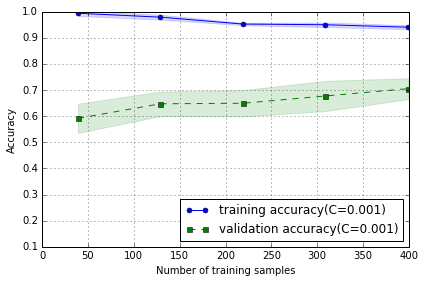

In [135]:
plt.plot(train_sizes, train_mean,
         color='blue', marker='o',
         markersize=5, label='training accuracy(C=0.001)')
plt.fill_between(train_sizes,
                 train_mean + train_std,
                 train_mean - train_std,
                 alpha=0.15, color='blue')
plt.plot(train_sizes, test_mean,
         color='green', linestyle='--',
         marker='s', markersize=5,
         label='validation accuracy(C=0.001)')
plt.fill_between(train_sizes,
                 test_mean + test_std,
                 test_mean - test_std,
                 alpha=0.15, color='green')

plt.grid()
plt.xlabel('Number of training samples')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.ylim([0.1, 1.0])
plt.tight_layout()
# plt.savefig('./figures/learning_curve.png', dpi=300)
plt.show()

- ↑ 過学習をしている（トレーニングデータの評価とテストデータの評価でギャップ（バリアンス）が大きい）
-  -> アクション1)トレーニングデータを増やす
-  -> アクション２)正則化パラメータの値を増やし、モデルをシンプルにする

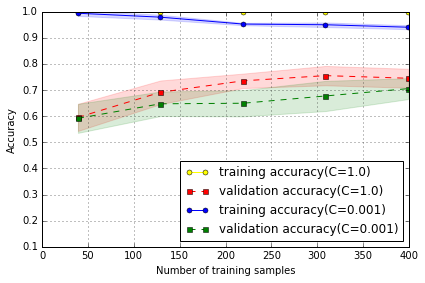

In [139]:
# 正則化パラメータを増やす
pipe_lr = Pipeline([('cov',CountVectorizer(ngram_range=(1, 3))),('clf', LogisticRegression(C=1.0,penalty='l2',random_state=1))])

c_train_sizes, c_train_scores, c_test_scores =\
                learning_curve(estimator=pipe_lr,
                               X=X,
                               y=y,
                               train_sizes=np.linspace(0.1, 1.0, 5),
                               cv=5,
                               n_jobs=1)

c_train_mean = np.mean(c_train_scores, axis=1)
c_train_std = np.std(c_train_scores, axis=1)
c_test_mean = np.mean(c_test_scores, axis=1)
c_test_std = np.std(c_test_scores, axis=1)

# 今回のプロット
plt.plot(c_train_sizes, c_train_mean,
         color='yellow', marker='o',
         markersize=5, label='training accuracy(C=1.0)')
plt.fill_between(c_train_sizes,
                 c_train_mean + c_train_std,
                 c_train_mean - c_train_std,
                 alpha=0.15, color='yellow')
plt.plot(c_train_sizes, c_test_mean,
         color='red', linestyle='--',
         marker='s', markersize=5,
         label='validation accuracy(C=1.0)')
plt.fill_between(c_train_sizes,
                 c_test_mean + c_test_std,
                 c_test_mean - c_test_std,
                 alpha=0.15, color='red')

#前回のプロット
plt.plot(train_sizes, train_mean,
         color='blue', marker='o',
         markersize=5, label='training accuracy(C=0.001)')
plt.fill_between(train_sizes,
                 train_mean + train_std,
                 train_mean - train_std,
                 alpha=0.15, color='blue')
plt.plot(train_sizes, test_mean,
         color='green', linestyle='--',
         marker='s', markersize=5,
         label='validation accuracy(C=0.001)')
plt.fill_between(train_sizes,
                 test_mean + test_std,
                 test_mean - test_std,
                 alpha=0.15, color='green')

plt.grid()
plt.xlabel('Number of training samples')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.ylim([0.1, 1.0])
plt.tight_layout()
# plt.savefig('./figures/learning_curve.png', dpi=300)
plt.show()

- 未知のデータに対する性能が上がった

In [133]:
# データ数を増やす
X2 = df.loc[:2000, 'review'].values
y2 = df.loc[:2000, 'sentiment'].values

d_train_sizes, d_train_scores, d_test_scores =\
                learning_curve(estimator=pipe_lr,
                               X=X2,
                               y=y2,
                               train_sizes=np.linspace(0.1, 1.0, 10),
                               cv=5,
                               n_jobs=1)

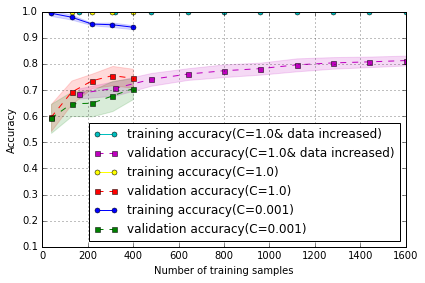

In [137]:
d_train_mean = np.mean(d_train_scores, axis=1)
d_train_std = np.std(d_train_scores, axis=1)
d_test_mean = np.mean(d_test_scores, axis=1)
d_test_std = np.std(d_test_scores, axis=1)

# 今回のプロット
plt.plot(d_train_sizes, d_train_mean,
         color='c', marker='o',
         markersize=5, label='training accuracy(C=1.0& data increased)')
plt.fill_between(d_train_sizes,
                 d_train_mean + d_train_std,
                 d_train_mean - d_train_std,
                 alpha=0.15, color='c')
plt.plot(d_train_sizes, d_test_mean,
         color='m', linestyle='--',
         marker='s', markersize=5,
         label='validation accuracy(C=1.0& data increased)')
plt.fill_between(d_train_sizes,
                 d_test_mean + d_test_std,
                 d_test_mean - d_test_std,
                 alpha=0.15, color='m')

# 前回のプロット
plt.plot(c_train_sizes, c_train_mean,
         color='yellow', marker='o',
         markersize=5, label='training accuracy(C=1.0)')
plt.fill_between(c_train_sizes,
                 c_train_mean + c_train_std,
                 c_train_mean - c_train_std,
                 alpha=0.15, color='yellow')
plt.plot(c_train_sizes, c_test_mean,
         color='red', linestyle='--',
         marker='s', markersize=5,
         label='validation accuracy(C=1.0)')
plt.fill_between(c_train_sizes,
                 c_test_mean + c_test_std,
                 c_test_mean - c_test_std,
                 alpha=0.15, color='red')

# 前々回のプロット
plt.plot(train_sizes, train_mean,
         color='blue', marker='o',
         markersize=5, label='training accuracy(C=0.001)')
plt.fill_between(train_sizes,
                 train_mean + train_std,
                 train_mean - train_std,
                 alpha=0.15, color='blue')
plt.plot(train_sizes, test_mean,
         color='green', linestyle='--',
         marker='s', markersize=5,
         label='validation accuracy(C=0.001)')
plt.fill_between(train_sizes,
                 test_mean + test_std,
                 test_mean - test_std,
                 alpha=0.15, color='green')


plt.grid()
plt.xlabel('Number of training samples')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.ylim([0.1, 1.0])
plt.tight_layout()
# plt.savefig('./figures/learning_curve.png', dpi=300)
plt.show()

## 検証曲線を使って過学習と学習不足を明らかにする<br>Addressing over- and underfitting with validation curves


In [142]:
# 計算時間を短くするため、データ数を減らす
print(len(X))
print(len(y))

500
500


In [143]:
# 「validation_curve」関数を使うと、「パラメータ」ー「精度」のグラフ（検定曲線）が書ける
from sklearn.learning_curve import validation_curve

param_range = [0.001, 0.01, 0.1, 1.0, 10.0, 100.0]
train_scores, test_scores = validation_curve(
                estimator=pipe_lr, 
                X=X, 
                y=y, 
                param_name='clf__C', 
                param_range=param_range,
                cv=10)

train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)

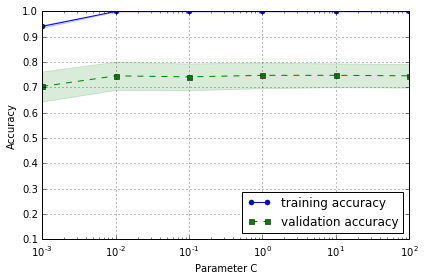

In [144]:
plt.plot(param_range, train_mean, 
         color='blue', marker='o', 
         markersize=5, label='training accuracy')
plt.fill_between(param_range, train_mean + train_std,
                 train_mean - train_std, alpha=0.15,
                 color='blue')

plt.plot(param_range, test_mean, 
         color='green', linestyle='--', 
         marker='s', markersize=5, 
         label='validation accuracy')
plt.fill_between(param_range, 
                 test_mean + test_std,
                 test_mean - test_std, 
                 alpha=0.15, color='green')

plt.grid()
plt.xscale('log')
plt.legend(loc='lower right')
plt.xlabel('Parameter C')
plt.ylabel('Accuracy')
plt.ylim([0.1, 1.0])
plt.tight_layout()
# plt.savefig('./figures/validation_curve.png', dpi=300)
plt.show()

- Cをさらに小さくすると、学習不足になりそう（バイアスが高くなりそう）
- Cを増やせば良さそう（validation accuracyが向上し、過学習がやわらぎそう（バリアンスが小さくなりそう））だが、データ数が足りない気がする

# 学習器のパラメータを調整する<br>（Fine-tuning machine learning models via grid search）

## グリッドサーチにより、ハイパーパラメータを選ぶ<br>Tuning hyperparameters via grid search

In [146]:
# 「GridSearchCV」クラスにより、網羅的に評価し、ベストパラメータを選択する
from sklearn.grid_search import GridSearchCV

# 前処理と学習器をパイプラインで一つにまとめる
pipe_lr = Pipeline([('cov',CountVectorizer()),
            ('clf',LogisticRegression(random_state=1))])

#　pipe_lrで設定した「('cov',　CountVectorizer())」　「('clf', LogisticRegression())])」に、パラメータの候補を用意する
param_grid = [{
               'cov__ngram_range':[(1, 1), (1, 2), (1, 3)],
               'clf__C': [0.0001, 0.01,  1.0,  100.0, 10000.0], 
               'clf__penalty': ['l1', 'l2']}]

# 「GridSearchCV」のインスタンスを生成
gs = GridSearchCV(estimator=pipe_lr, 
                  param_grid=param_grid, 
                  scoring='accuracy', 
                  cv=5,
                  n_jobs=1)

# 学習（最も良いパラメータを選ぶ）
gs = gs.fit(X_train, y_train)

# ベストスコア出力
print(gs.best_score_)
# ベストパラメータ出力
print(gs.best_params_)

0.805
{'clf__penalty': 'l1', 'clf__C': 10000.0, 'cov__ngram_range': (1, 1)}


In [147]:
gs.grid_scores_

[mean: 0.49250, std: 0.00250, params: {'clf__penalty': 'l1', 'clf__C': 0.0001, 'cov__ngram_range': (1, 1)},
 mean: 0.49250, std: 0.00250, params: {'clf__penalty': 'l1', 'clf__C': 0.0001, 'cov__ngram_range': (1, 2)},
 mean: 0.49250, std: 0.00250, params: {'clf__penalty': 'l1', 'clf__C': 0.0001, 'cov__ngram_range': (1, 3)},
 mean: 0.58500, std: 0.02078, params: {'clf__penalty': 'l2', 'clf__C': 0.0001, 'cov__ngram_range': (1, 1)},
 mean: 0.57500, std: 0.01885, params: {'clf__penalty': 'l2', 'clf__C': 0.0001, 'cov__ngram_range': (1, 2)},
 mean: 0.57750, std: 0.02194, params: {'clf__penalty': 'l2', 'clf__C': 0.0001, 'cov__ngram_range': (1, 3)},
 mean: 0.50750, std: 0.01406, params: {'clf__penalty': 'l1', 'clf__C': 0.01, 'cov__ngram_range': (1, 1)},
 mean: 0.50750, std: 0.01406, params: {'clf__penalty': 'l1', 'clf__C': 0.01, 'cov__ngram_range': (1, 2)},
 mean: 0.50750, std: 0.01406, params: {'clf__penalty': 'l1', 'clf__C': 0.01, 'cov__ngram_range': (1, 3)},
 mean: 0.73000, std: 0.05144, para

## 入れ子の交差検定によるアルゴリズムの選択<br>Algorithm selection with nested cross-validation
- このタスク（このデータセット）では、support vector macineがいいか、logistic regressionがいいか、等、どの学習アルゴリズムがいいか評価できる

In [148]:
# logistic regression
# 「cross_val_score」で評価する際、「GridSearchCV」のモデル選択により得られたベストの評価値で評価する　
gs = GridSearchCV(estimator=pipe_lr,
                  param_grid=param_grid,
                  scoring='accuracy',
                  cv=2)

# Note: Optionally, you could use cv=2 
# in the GridSearchCV above to produce
# the 5 x 2 nested CV that is shown in the figure.

scores = cross_val_score(gs, X, y, scoring='accuracy', cv=5)
print('CV accuracy: %.3f +/- %.3f' % (np.mean(scores), np.std(scores)))

CV accuracy: 0.806 +/- 0.019


In [151]:
# support vector machine
from sklearn.svm import SVC
# 前処理と学習器をパイプラインで一つにまとめる
pipe_svm = Pipeline([('cov',CountVectorizer()),
            ('clf',SVC(random_state=1))])

#　pipe_svmで設定した「('cov',　CountVectorizer())」　「('clf',SVC())」に、パラメータの候補を用意する

param_range=[0.0001, 0.01,  1.0,  100.0, 10000.0]
param_grid = [{'clf__C': param_range, 
               'clf__kernel': ['linear']},
                 {'clf__C': param_range, 
                  'clf__gamma': param_range, 
                  'clf__kernel': ['poly']}]


# 「GridSearchCV」のインスタンスを生成
gs = GridSearchCV(estimator=pipe_svm, 
                  param_grid=param_grid, 
                  scoring='accuracy', 
                  cv=2,
                  n_jobs=1)
scores = cross_val_score(gs, X_train, y_train, scoring='accuracy', cv=5)
print('CV accuracy: %.3f +/- %.3f' % (np.mean(scores), np.std(scores)))

CV accuracy: 0.730 +/- 0.054


# さまざまな性能評価指標<br>Looking at different performance evaluation metrics

## Reading a confusion matrix

In [57]:
from sklearn.metrics import confusion_matrix

pipe_lr.fit(X_train, y_train)
y_pred = pipe_lr.predict(X_test)
confmat = confusion_matrix(y_true=y_test, y_pred=y_pred)
print(confmat)

[[32 12]
 [12 45]]


|  | positive(予測) | negative(予測) |
|:-----------|:------------|:------------|
| positive(実際)　| positiveと予測したものが、positiveであるデータの個数 | negativeと予測したものが、positiveであるデータの個数  |
| negative(実際) | positiveと予測したものが、negativeであるデータの個数 | negativeと予測したものが、negativeであるデータの個数 |

|  | positive(予測) | negative(予測) |
|:-----------|:------------|:------------|
| positive(実際)　| True Positve (TP) | False Negative (FN)  |
| negative(実際) | False Positive (FP) | True Negative (TN) |


## 分類モデルの適合率と再現率を最適化する<br>Optimizing the precision and recall of a classification model

In [59]:
from sklearn.metrics import precision_score, recall_score, f1_score

print('Precision: %.3f' % precision_score(y_true=y_test, y_pred=y_pred))
print('Recall: %.3f' % recall_score(y_true=y_test, y_pred=y_pred))
print('F1: %.3f' % f1_score(y_true=y_test, y_pred=y_pred))

Precision: 0.789
Recall: 0.789
F1: 0.789


In [60]:

from sklearn.metrics import make_scorer

scorer = make_scorer(f1_score, pos_label=0)

pipe_lr = Pipeline([('cov',CountVectorizer(ngram_range=(1, 3))),
            ('clf', LogisticRegression(random_state=1))])

#penalty='l2', 
param_range = [0.0001, 0.001, 0.01, 0.1, 1.0, 10.0, 100.0, 1000.0]

param_grid = [{'clf__C': param_range, 
               'clf__penalty': ['l1']},
                 {'clf__C': param_range, 
                  'clf__penalty': ['l2']}]

gs = GridSearchCV(estimator=pipe_lr,
                  param_grid=param_grid,
                  scoring=scorer,
                  cv=10,
                  n_jobs=-1)
gs = gs.fit(X_train, y_train)
print(gs.best_score_)
print(gs.best_params_)

0.78510577249
{'clf__C': 1000.0, 'clf__penalty': 'l1'}


/Users/manabki/.pyenv/versions/anaconda3-2.5.0/lib/python3.5/site-packages/sklearn/metrics/classification.py:1074: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/manabki/.pyenv/versions/anaconda3-2.5.0/lib/python3.5/site-packages/sklearn/metrics/classification.py:1074: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/manabki/.pyenv/versions/anaconda3-2.5.0/lib/python3.5/site-packages/sklearn/metrics/classification.py:1074: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/manabki/.pyenv/versions/anaconda3-2.5.0/lib/python3.5/site-packages/sklearn/metrics/classification.py:1074: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precisio